# Setup

In [21]:
%load_ext autoreload
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Resources Download

In [9]:
%autoreload 2
from DeepDNA_sources.DL_helping import download_demo_resources

download_demo_resources()

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors
Retrieving folder contents
tar: This does not look like a tar archive
tar: Skipping to next header


Processing file 1-Wj9qaliLW1CUzv3IH3ZPens0DJIAFxB CDK9as.estimates.txt
Processing file 1rJuoP2u7wl94h2nSNfjCtWX1cydeTJqx Kouzine.bed


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-Wj9qaliLW1CUzv3IH3ZPens0DJIAFxB
To: /home/xbostick/work/study/GAN_Z/DeepDNA/data/CDK9as.estimates.txt
100%|██████████| 563k/563k [00:00<00:00, 4.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rJuoP2u7wl94h2nSNfjCtWX1cydeTJqx
To: /home/xbostick/work/study/GAN_Z/DeepDNA/data/Kouzine.bed
100%|██████████| 1.01M/1.01M [00:00<00:00, 7.84MB/s]
Download completed


AttributeError: '_io.TextIOWrapper' object has no attribute 'communicate'

# Data1

In [22]:
features_data = pd.read_csv("./data/CDK9as.estimates.txt",sep = "\t",na_values="None")

In [6]:
features_data.head()

,chr,strand,start,end,type,source,length,id,response.ratio.five.prime,response.ratio.three.prime,elongation.rate,initiation.rate.per.cell,pause.duration,initiation.rate.per.cell.inhibited,pause.duration.inhibited,pause.duration.without.I,elongation.rate.without.r,gene_id,transcript_id
TR00033,chr1,+,2228695,2310213,transcribed_region,REFSEQ_merge,81519,TR00033,0.549913,0.18976,4382.308103,0.712755,2.989587,0.320802,0.486897,0.238582,3227.8,ENSG00000157933,NM_003036
TR00034,chr1,+,2391775,2405446,transcribed_region,REFSEQ_merge,13672,TR00034,0.629192,NaN,NaN,1.929608,0.942502,0.715513,2.778217,NaN,NaN,ENSG00000157916,NM_007033
TR00037,chr1,+,2566535,2584534,transcribed_region,REFSEQ_merge,18000,TR00037,0.000000,NaN,NaN,0.119737,NaN,0.119737,NaN,NaN,NaN,NaN,NR_121638
TR00047,chr1,+,3900404,3915447,transcribed_region,REFSEQ_merge,15044,TR00047,0.538403,NaN,NaN,0.228522,20.915492,0.105485,32.879122,NaN,NaN,ENSG00000236423,NR_024455
TR00059,chr1,+,6613696,6624033,transcribed_region,REFSEQ_merge,10338,TR00059,0.716341,NaN,NaN,0.563993,1.848106,0.159982,2.004466,NaN,NaN,ENSG00000116273,NM_153812


# First Step Example (Regression models)

## data extraction

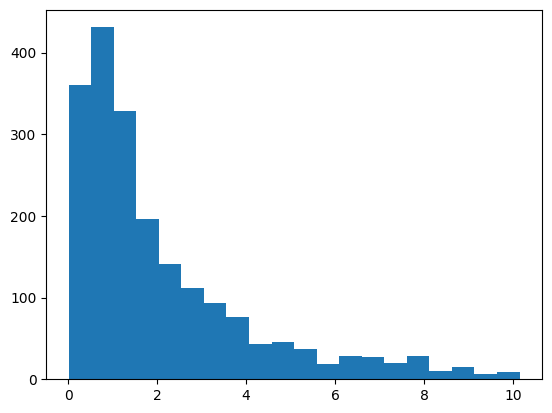

In [23]:
Pause_data = features_data[features_data["pause.duration"].notna()]
Pause_data = Pause_data[Pause_data["pause.duration"] < Pause_data["pause.duration"].quantile(0.95)]
_ = plt.hist(Pause_data["pause.duration"], bins = 20)
plt.show()

In [24]:
from DeepDNA_sources.DNA_Dataset import GenomicData

data = GenomicData("./data/hg38.fa",Pause_data,1000,200,"pause.duration", keep_none=True)

In [ ]:
from torch import Generator
from torch.utils.data import random_split, DataLoader 

In [ ]:
train_size = int(0.9 * len(data))
test_size = len(data) - train_size

g_cpu = Generator()
g_cpu.manual_seed(666)
train_dataset, test_dataset = random_split(data, [train_size, test_size],g_cpu)

train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

## model learning

In [ ]:
from DeepDNA_sources.Models import DNA_2_Bio_Regression
model = DNA_2_Bio_Regression(seq_size = 1200).cuda()

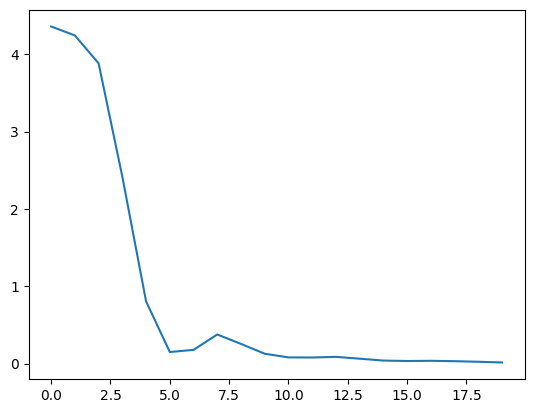

100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


R2_test = -0.10153865814208984 
                RMSE_test = 2.3579370975494385 
                MAPE_test = 2.903735637664795
                MAE_test = 1.733549952507019
                R2_train = 0.9785123467445374
                RMSE_train = 0.2968592941761017
                MAPE_train = 0.32027849555015564
                MAE_train = 0.24297460913658142



In [ ]:
%autoreload 2
import torch
import torch.nn as nn
from DeepDNA_sources.DL_helping import regression_learning, regression_val

b1 = 0.9
b2 = 0.999
lr = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1,b2))
scheduler =  torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

x = regression_learning(model,optimizer,scheduler, criterion,train_loader,n_epoch=20, verbose=True)
regression_val(model,test_loader,train_loader)

# GAN + ZDNA

In [ ]:
features_data = pd.read_csv("./data/Kouzine.bed",sep = "\t",na_values="None", names=["chr", "start", "end"])

In [ ]:
min_len = np.quantile(features_data.apply(lambda x : x["end"] - x["start"], axis = 1),0.01)
max_len = np.quantile(features_data.apply(lambda x : x["end"] - x["start"], axis = 1),0.99)

def data_prep(series_raw):
    delta = series_raw["end"] - series_raw["start"]
    if min_len < delta < max_len:
        return None
    else:
        return series_raw.name

In [ ]:
from DeepDNA_sources.DNA_Dataset import GenomicData_ZDNA

dropped = pd.DataFrame(features_data.apply(data_prep, axis=1))
features_data.drop(index = dropped.dropna().iloc[:,0], inplace= True)
d = GenomicData_ZDNA("../data/hg19.fa",features_data,max_len)

## ZDNA_GAN + BERT

In [ ]:
hist_real = np.zeros(d[0].T.shape, dtype = int)
names = ["A","T","G","C","N"]
for i in d:
    for pos, nucl in enumerate(torch.argmax(i.cpu(), dim = 1)):
        hist_real[nucl][pos] += 1
nucl_hits_natural = { name: sum(hist_real[i]) for i,name in enumerate(names)}

### model_GAN


In [ ]:
%load_ext autoreload
%autoreload 2
from DeepDNA_sources.Models import DNA_Seq_Generator, DNA_Seq_Critic
from DeepDNA_sources.BertImpl import init_bert
from DeepDNA_sources.DL_helping import GAN_learning_ZDNA

init_bert()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


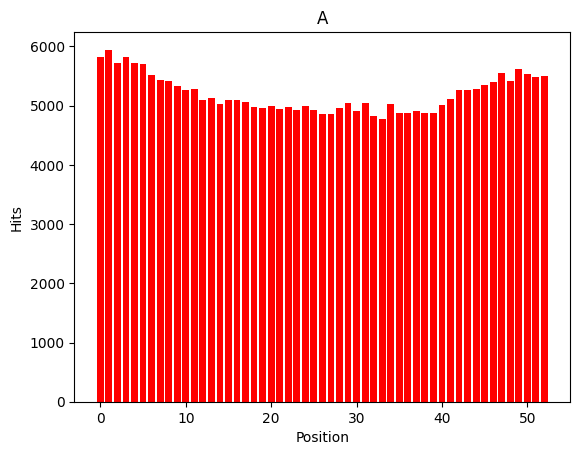

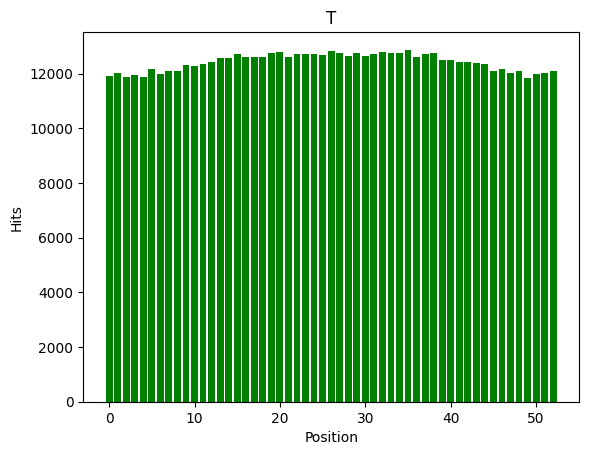

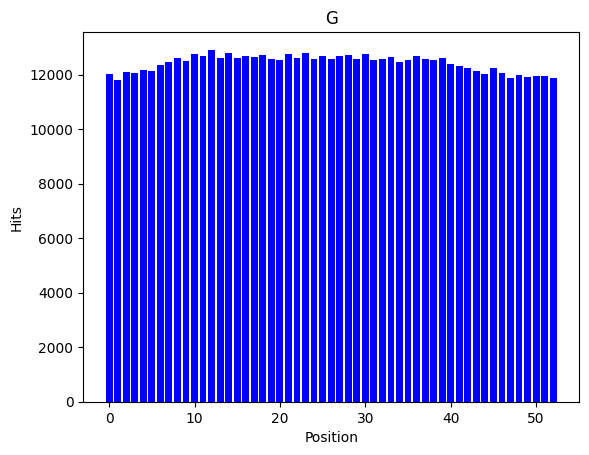

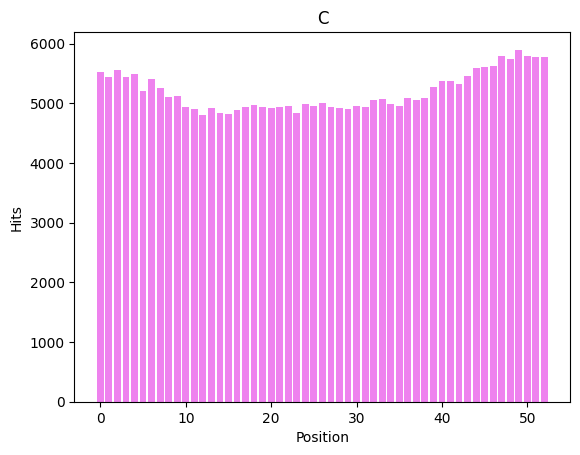

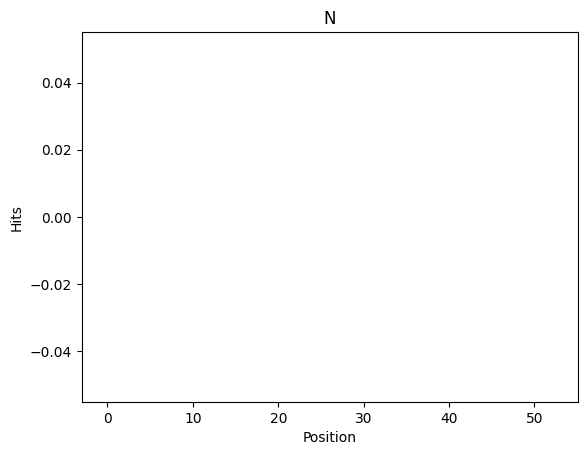

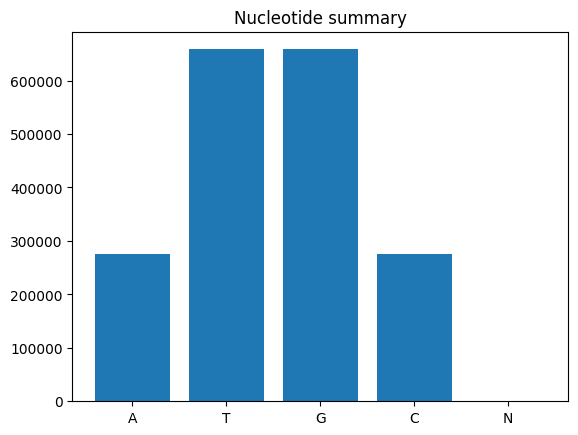

In [ ]:
from DeepDNA_sources.DL_helping import get_genomic_data_stats

hist_real, nucl_hits_natural = get_genomic_data_stats(d, verbose = True)

In [ ]:
generator= DNA_Seq_Generator().cuda()
discriminator = DNA_Seq_Critic(max_seq_len = len(d[0])).cuda()

In [ ]:
dataloader = DataLoader(d)
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=1e-6)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=1e-6)

IR_Gen,_,GC =GAN_learning_ZDNA(generator,discriminator,optimizer_D,optimizer_G,dataloader,hist_real,nucl_hits_natural, lr = 1e-6, n_epochs=2)
#clear_output()